## Representational State Transfer (REST) API

(1) This notebook works with Python 2.7.<br>
(2) MDCS should be running on background.<br>
(3) For more examples for REST api, check http://127.0.0.1:8000/docs/api.<br>

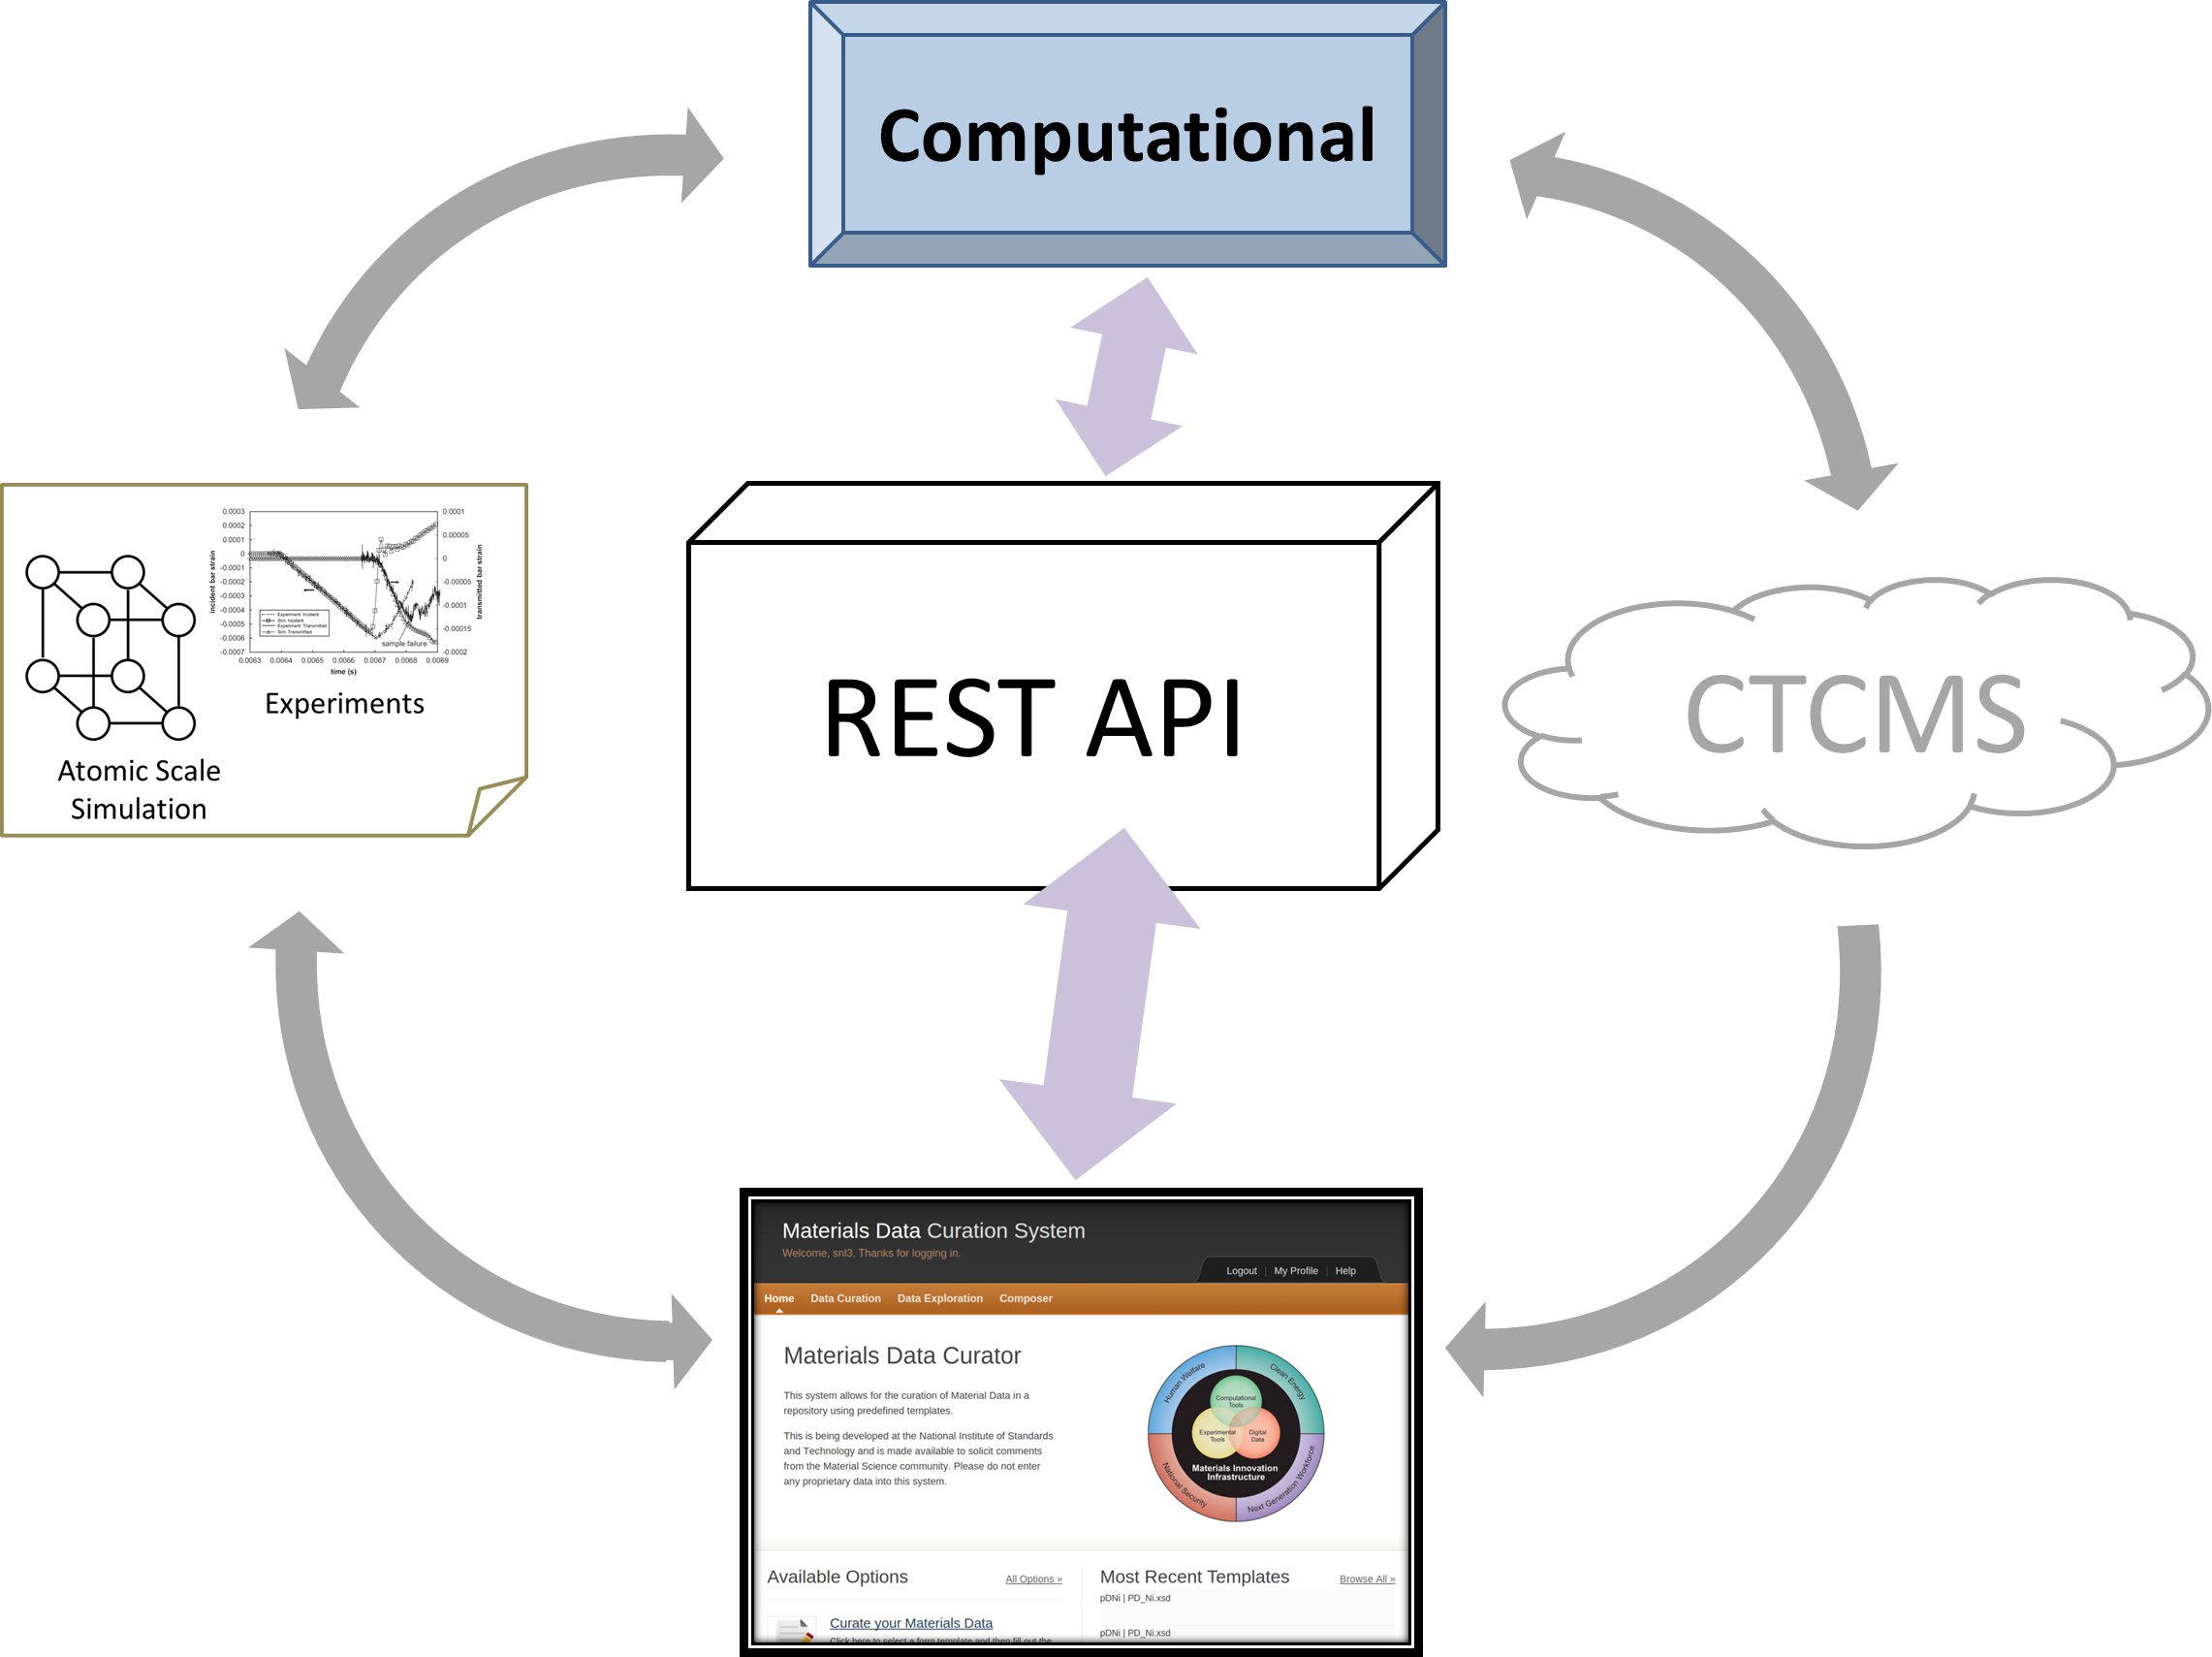

In [1]:
from IPython.display import Image
Image("workflow.png", width=600)

## Import libraries for Python

In [2]:
# -------------------------------------------- General Python library
import glob, os                           # Python standard library
import sys                                # Python standard library
import time                               # Python standard library
import unicodedata                        # Python standard library
import numpy as np                        # NEED to be installed

# -------------------------------------------- API
import json                               # Python standard library
import requests                           # NEED to be installed

# -------------------------------------------- XML Schemas
import xml.dom.minidom                    # Python standard library
from xml.dom.minidom import parseString   # Python standard library
import collections                        # Python standard library

# https://pypi.python.org/pypi/xmltodict
import xmltodict                          # attached
# https://pypi.python.org/pypi/dicttoxml
import dicttoxml                          # attached

# -------------------------------------------- convert .XLSX to .XML files
# http://www.python-excel.org/
import xlrd                               # NEED to be installed


# -------------------------------------------- Matplotlib for plotting
                                          # NEED to be installed
# http://matplotlib.org/
import matplotlib.pyplot as plt
import matplotlib.colorbar as clb
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from matplotlib import ticker
from matplotlib.ticker import LogLocator
%matplotlib inline

## Personal information at MDCS

In [3]:
# ---- setup information to sign in MDCS
USER = "admin"
PSWD = "admin"
MDCS_URL = "http://127.0.0.1:8000"

=============================================================
## Database status of MDCS

### (1) Counting the number of Schema

In [4]:
# url is needed in order to communicate with REST api
# to select ALL the schemas in the database, the url is
# "/rest/templates/select/all"
url = MDCS_URL + "/rest/templates/select/all"

# sending the request by url and pass the results to the Python list "allSchemas"
allSchemas = json.loads(requests.get(url, auth=(USER, PSWD)).text)

# counting the number schemas of the list
print "Number of Schemas: ",len(allSchemas)

# print the details of the schema
# schema/templet ID is the key to post/query data so it's printed out here
for i in range(len(allSchemas)):
    print "Schema %s: %s" % (allSchemas[i]['title'],allSchemas[i]['id'])

Number of Schemas:  16
Schema DSC_s: 56ec3eff1ff0f311d9762c18
Schema mod_demo_diffusion0224: 56ce39e51ff0f30d02759a76
Schema interDiffusion: 56ce3e601ff0f30d02759f2b
Schema demoTEM: 56cea6871ff0f30e114e50af
Schema wsTEM: 56cf3f711ff0f30c3c623b12
Schema mod_demo_diffusion0225: 56cf62601ff0f30c3c62415f
Schema mod_demo_diffusion0225: 56cf63841ff0f30c3c6242d2
Schema mod_demo_diffusion0225: 56cf64821ff0f30c3c62440e
Schema mod_demo_diffusion0225: 56cf6dd61ff0f30c3c624757
Schema mod_demo_diffusion0225: 56cf6f331ff0f30c3c62483d
Schema diffu_SY2: 56cf71531ff0f30c3c624979
Schema thermalanalysis: 56e846471ff0f3119c9bbb3f
Schema thermalanalysis: 56e97cf61ff0f3100de42edc
Schema thermalanalysis: 56e97e741ff0f3100de42f7a
Schema interDiffusion: 5720e2511ff0f31620f6cafd
Schema interDiffusion: 5720e9701ff0f31620f6cb00


### (2) Counting the number of XMLs

for schemas the url is   "/rest/<font color='blue'>templates</font>/select/all"<br>
for xml files the url is "/rest/<font color='blue'>explore</font>/select/all"

In [5]:
url = MDCS_URL + "/rest/explore/select/all"
allXMLs = json.loads(requests.get(url, auth=(USER, PSWD)).text)

print "Number of XMLs: ",len(allXMLs)

Number of XMLs:  211


=============================================================
## Case Study - diffusion couple experiment

### Problem Statement: 
A spreadsheet of diffusion couple data need to be stored.

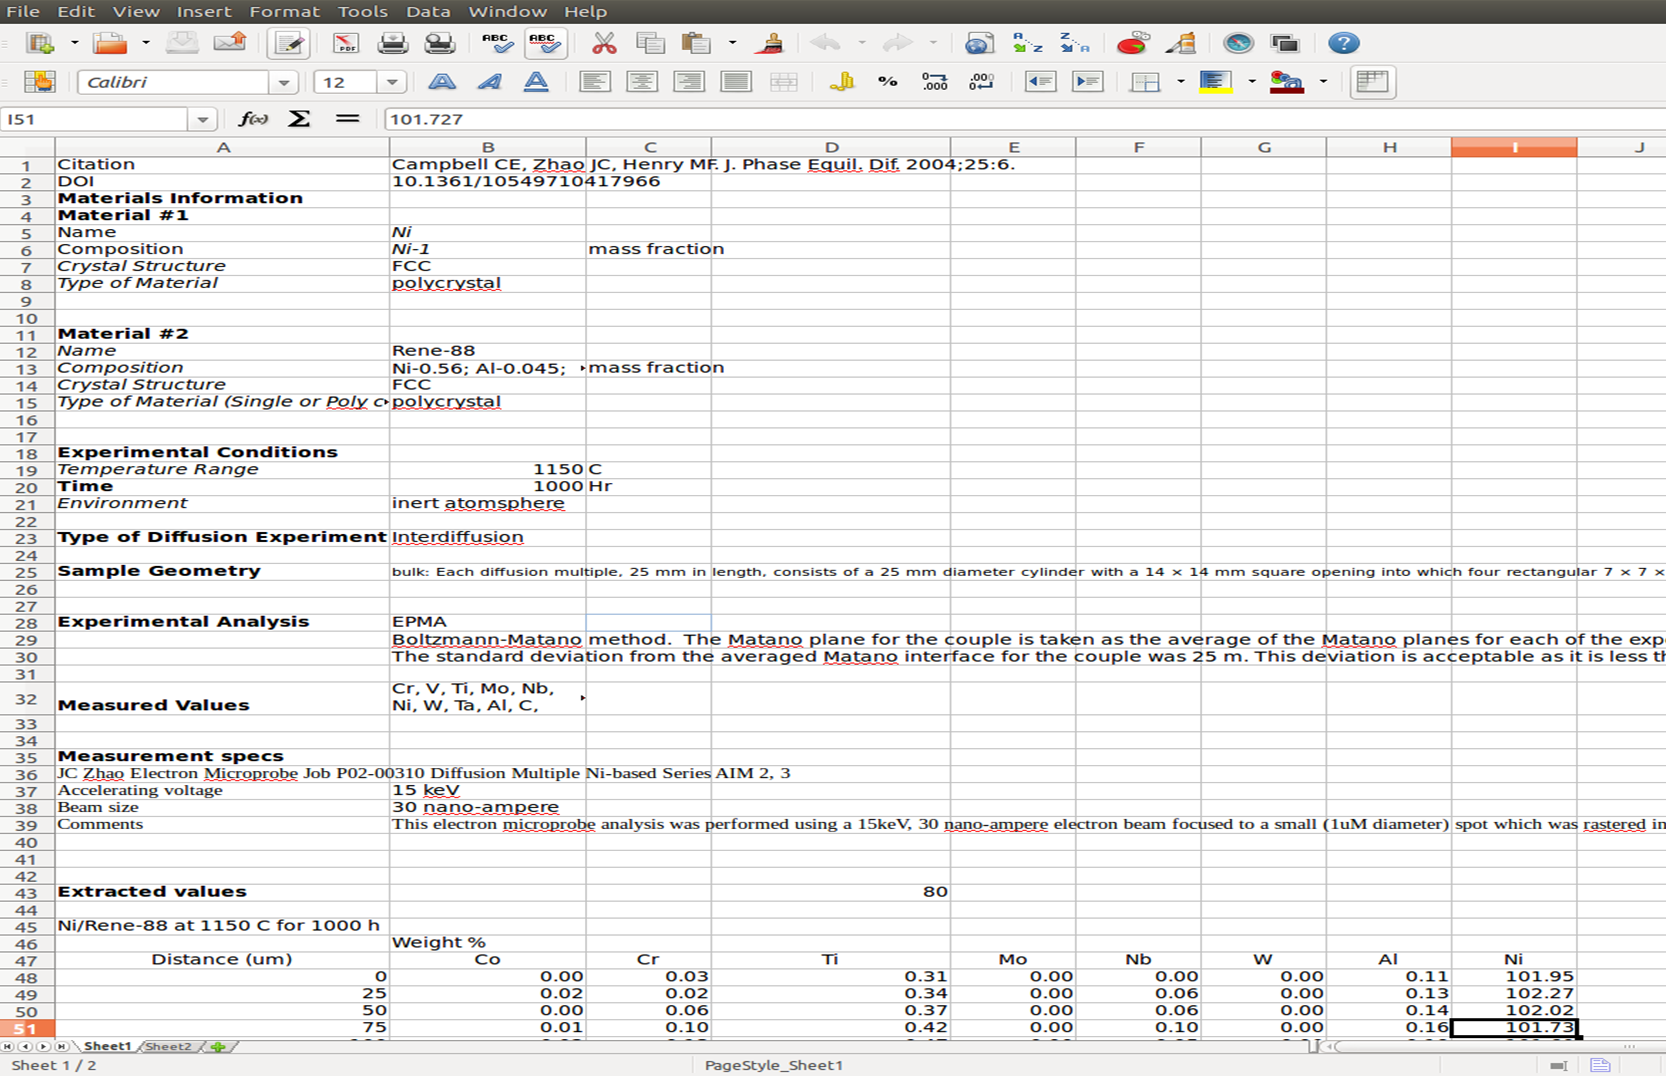

In [6]:
Image("xlsx.png", width=600)

### Solution:
data preparation<br>
(a) design a schema (Interdiffusion3-LT.xsd) for this spreadsheet<br>
(b) load data using xmltodict in Python<br>
(c) write data to interdiffusion.xml file using dicttoxml library<br>
<br>
REST api<br>
(d) push Interdiffusion3-LT.xsd to MDCS<br>
(e) post interdiffusion.xml to MDCS<br>
(f) query and visualize the data under this schema<br>

### The schema for diffusion couple

print out the pre-designed schema

In [ ]:
#%pycat Interdiffusion3-LT.xsd

## XMLs preparation from .xlsx file

### open file --> get table name --> load data by table name

get files

In [7]:
# glob.glob is included in default Python library for 
# communicating with the file system
xlsx_files = glob.glob("xlsx/Ni-R88*.xlsx")
print xlsx_files

['xlsx/Ni-R88-Campbell.xlsx']


Open the first file and read the name(s) of the sheet(s) to "xlfile"

In [8]:
# xlrd is the library used to read xlsx file
# https://secure.simplistix.co.uk/svn/xlrd/trunk/xlrd/doc/xlrd.html?p=4966
xlfile = xlrd.open_workbook(xlsx_files[0])

sheet_name = []
# find out the names of the spreadsheets of the first file
sheet_name = xlfile.sheet_names()

print ("Number of the sheet in the file: ",
       len(sheet_name),"; Name: ", sheet_name)

('Number of the sheet in the file: ', 2, '; Name: ', [u'Sheet1', u'Sheet2'])


Read data to the Python list "sheet_content"

In [9]:
sheet_content = []

# only read the first sheet
for sh in range(1):
    # xlfile.sheet_by_name is the function read the sheet by it's "name"
    sheet_content.append(xlfile.sheet_by_name(sheet_name[sh]))

    # information of the sheet: how many rows and columns
    print "Number of rows:",sheet_content[0].nrows
    print "Number of columns:",sheet_content[0].ncols

Number of rows: 128
Number of columns: 18


Print out the content of the file

In [ ]:
#for no_row in range(sheet_content[0].nrows):
#    print sheet_content[0].row_values(no_row)

### Write the content from .XLSX to .XML
Using dictoxml to write the xml file, the data need to be prepared as Python dictionary.<br>
While the sheet is too large, iPython notebook can not handle the writting in one execution. <br>
Run the following cell twice.

In [10]:
#-------------------------------define the lists for the schma structure
diffusionData = []
experimenttype = []
material = []
experimentalConditions = []
measurementspecs = ''
measurementDescription = ''
measuredvalues = []
reference = ''
citation = []
doi = ''
row_value = []
time_type = []
time=''
temperature_type = []
temperature=''
env=''

# scan through the sheet and write the information in each block
# (refer to the note) to the schema module
for no_row in range(sheet_content[0].nrows):
    # the number type belongs to block #6, so it's not handled here
    if(type(sheet_content[0].row_values(no_row)[0]) is float):
        continue

# -- material (block #2)
    # #2 block includes the material information 
    if(sheet_content[0].row_values(no_row)[0][:10]=='Material #'):

        # 'MaterialName' is the xml tag for the name of material
        # sheet_content[0]      -- first table
        # row_values(no_row+1)  -- row number no_row+1
        # [1]                   -- second value
        material.append({'MaterialName':
                         sheet_content[0].row_values(no_row+1)[1]})

        # 'CrystalStructure', the tag for crystal structure
        material.append({'CrystalStructure':
                         sheet_content[0].row_values(no_row+3)[1]})

        # separate the string by ';'
        element_list=sheet_content[0].row_values(no_row+2)[1].split(';')
        for ele in range(len(element_list)):
            # separate the string by '-'
            element=str(element_list[ele]).split('-')
            # the minimum and maximum of the composition
            comprange = []
            comprange.append(({'min':element[1]},{'max':element[1]}))
            # 'element'-'CompositionRange' (comprange)-'quantityunit'
            comp = []
            comp.append(({'element':element[0].strip(' ')},
                         {'CompositionRange':comprange},
                         {'quantityUnit':
                          sheet_content[0].row_values(no_row+2)[2]}))
            material.append({'Composition':comp})

        material.append({'materialForm':
                         sheet_content[0].row_values(no_row+4)[1]})

# --exp conditions (block #3)
    if(sheet_content[0].row_values(no_row)[0][:11]=='Temperature'):
        temperature=sheet_content[0].row_values(no_row)[1]
        temperature_unit=sheet_content[0].row_values(no_row)[2]
    if(sheet_content[0].row_values(no_row)[0][:4]=='Time'):
        time=sheet_content[0].row_values(no_row)[1]
        time_unit=sheet_content[0].row_values(no_row)[2]
    if(sheet_content[0].row_values(no_row)[0][:11]=='Environment'):
        env=sheet_content[0].row_values(no_row)[1]

# --measurement specs (block #4)
    if(sheet_content[0].row_values(no_row)[0][:17]=='Measurement specs'):
        measurementspecs=(str(sheet_content[0].row_values(no_row+1)[0])
                        +str(sheet_content[0].row_values(no_row+2)[0])
                        +str(sheet_content[0].row_values(no_row+2)[1])
                        +str(sheet_content[0].row_values(no_row+3)[0])
                        +str(sheet_content[0].row_values(no_row+3)[1])
                        +str(sheet_content[0].row_values(no_row+4)[0])
                        +str(sheet_content[0].row_values(no_row+4)[1]))
        #print measurementspecs
        

    if(sheet_content[0].row_values(no_row)[0][:16]=='Extracted values'):
# --measured value (block #5)
        measurementDescription=sheet_content[0].row_values(no_row+2)[0]
        
        non_empty_col = len(filter(None, sheet_content[0].row_values(no_row+4)))
        non_empty_row = sheet_content[0].nrows - (no_row+5)
        
        for non_empty_row in range(no_row+5,sheet_content[0].nrows):
            if(type(sheet_content[0].row_values(non_empty_row)[0]) is not float):
                break   
    
# --measured value (block #6)
        non_empty_row-=(no_row+4)
        for tab_row in range(no_row+5,no_row+5+non_empty_row,1):
            for tab_col in range(non_empty_col):
                row_value.append({'quantity':
                                  sheet_content[0].row_values(no_row+4)[tab_col]})
                row_value.append({'value':
                                  sheet_content[0].row_values(tab_row)[tab_col]})
                #measuredvalues.append({'measuredValues':row_value})

# -- reference (block #1)
    if(sheet_content[0].row_values(no_row)[0][:8]=='Citation'):
        reference=sheet_content[0].row_values(no_row)[1]
    if(sheet_content[0].row_values(no_row)[0][:4]=='DOI'):
        doi=sheet_content[0].row_values(no_row)[1]

# summarize some types
temperature_type.append(({'value':temperature},
                         {'unit':temperature_unit}))
time_type.append(({'value':time},{'unit':time_unit}))
experimentalConditions.append(({'time':time_type},
                               {'temperature':temperature_type},
                               {'environment':env}))


# assemble the blocks #1-#6
diffusionData.append(('experimentalDetails',
             ({'material':material},                             # 2
              {'experimentalConditions':experimentalConditions}, # 3
              {'measurementSpec':measurementspecs},              # 4
              {'measurementDescription':measurementDescription}, # 5
              {'measuredValues':row_value})))                    # 6
diffusionData.append(('citation',
                    ({'reference':reference},{'doi':doi})))      # 1

# organize the Python dictionary
# https://docs.python.org/2/library/collections.html#collections.OrderedDict
diffusionData = collections.OrderedDict(diffusionData)

# using dicttoxml library to convert dictionary to xml
# the root of xml is 'interDiffusion'
# type attribute is the type in tag; eq <doi type='str'>xxxxx</doi>
diffusionDataxml = dicttoxml.dicttoxml(diffusionData,
                                       custom_root='interDiffusion',
                                       attr_type=False)

# write information to interdiffusion.xml
filename = str('data/interdiffusion.xml')
interdiffusionschema = open(filename, 'w')
interdiffusionschema.write("%s\n" % 
            (parseString(diffusionDataxml).toprettyxml()))
interdiffusionschema.close()

Check the outputs

In [ ]:
#%pycat data/interdiffusion.xml

## Push schema to MDCS

This schema is designed previously using Oxygen<br>
In this cell, we push this schema to MDCS and get the schema ID

In [12]:
file = open('Interdiffusion3-LT.xsd','r')
templateContent = file.read()

# calling the function by the url for pushing schema
url = MDCS_URL + "/rest/templates/add"

# to push schema you need to define
# (1)"title" of the schema  (2)"filename" of the schema in MDCS
# (3)"content" of the schema
push_data = {"title":"interDiffusion",
        "filename": "interDiffusionschema.xsd",
        "content": templateContent}

# post it
pSchema = json.loads(requests.post(url, push_data,
                                   auth=(USER, PSWD)).text)

# get schema/templet ID
templateId = pSchema['_id']['$oid']

print "Schema ID:",templateId

Schema ID: 5720ed2e1ff0f31620f6cb03


## Post data

find out the path of the .xml file

In [13]:
push_files = glob.glob("data/interdiffusion*.xml")

print "Number of .XML to post",len(push_files)

Number of .XML to post 1


post xml to MDCS

In [14]:
import time

# claim the URL path for posting
url = MDCS_URL + "/rest/curate"

# sequentially
# open and post .xml file(s)
for pfile in push_files:
    opfile = open(pfile,'r')
    fileContent = opfile.read()
    
    # api function
    # define (1) "title" of the xml  (2) which "schema" 
    # you want to push to  (3) the "content" of xml
    data_to_send = {"title": "diffusion"+str(time.time())
                                        +str(time.clock())+".xml",
                    "schema":templateId,"content":fileContent}

    # post the data using request library
    r = requests.post(url, data_to_send, auth=(USER, PSWD))

## Query and plot the results

define the plot function for this specific case

## Setup plot function

In [15]:
def plot(samNo,samContent):
    fig, ax = plt.subplots(figsize=(12, 9))

    # -------------- parameters for plots
    titlesize=35
    labelsize=25
    labelpad=15
    pad=5
    p_alpha = 0.5
    vsize = 10
    flabsize = 40
    fticksize = 30
    # --------------
    
    content = []
    x = []
    y = []

    for i in range(samNo):
        # the query results in xml format are stored as 
        # Python list "samContent"
        # use xmltodict library to convert xml format to 
        # Python dictionary
        # 'content' is the standard head from request
        # toprettyxml makes the output in organized shape
        content = (xmltodict.parse(xml.dom.minidom
                        .parseString(samContent[i]['content']).toprettyxml()))
        
        # according to the schema defined before, 
        # the physical quantities are stored in the path of
        # 'interDiffusion'-->'experimentalDetails'
        #    -->'measuredValues'-->'quantity'
        # the measuerd values are
        # 'interDiffusion'-->'experimentalDetails'
        #    -->'measuredValues'-->'value'
        x.append(content['interDiffusion']['experimentalDetails']
                 ['measuredValues']['quantity'])
        y.append(content['interDiffusion']['experimentalDetails']
                 ['measuredValues']['value'])
    
    # x and y are the long python lists
    # numpy .reshape recovers them to a numerical table for plotting
    x = np.asarray(x).reshape(-1,non_empty_col)
    y = np.asarray(y).reshape(-1,non_empty_col)

    ax.plot(y[:,0],y[:,1],'o-', ms=vsize, c='b', label=x[0,1])
    ax.plot(y[:,0],y[:,2],'o-', ms=vsize, c='g', label=x[0,2])
    ax.plot(y[:,0],y[:,3],'o-', ms=vsize, c='r', label=x[0,3])
    ax.plot(y[:,0],y[:,4],'o-', ms=vsize, c='c', label=x[0,4])
    ax.plot(y[:,0],y[:,5],'o-', ms=vsize, c='m', label=x[0,5])
    ax.plot(y[:,0],y[:,6],'o-', ms=vsize, c='y', label=x[0,6])
    ax.plot(y[:,0],y[:,7],'o-', ms=vsize, c='k', label=x[0,7])
    ax.plot(y[:,0],y[:,8],'o-', ms=vsize, c='w', label=x[0,8])

    ax.set_xlabel(x[0,0], fontsize=flabsize, labelpad=15)
    ax.set_ylabel('w, %', fontsize=flabsize, labelpad=15)

    ax.tick_params(axis='x', labelsize=fticksize, pad = 10, colors='black')
    ax.tick_params(axis='y', labelsize=fticksize, pad = 10, colors='black')

    ax.xaxis.grid(True)

    ax.set_xlim(0,2000)
    ax.set_ylim(0,110)
    
    ax.locator_params(axis = 'x', nbins = 4)
    ax.locator_params(axis = 'y', nbins = 3)

    handles, labels = ax.get_legend_handles_labels()
    
    ax.legend(handles, labels, bbox_to_anchor=(0.25, 0.8), fontsize=25)
    
    fig.tight_layout()
    plt.show()

    return (x,y)


## query by schema/templateId

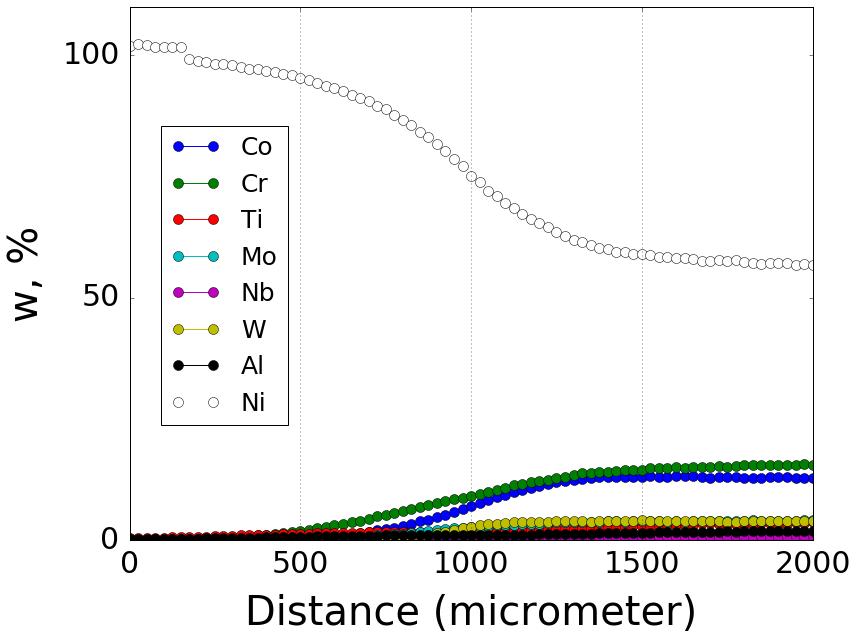

In [16]:
X = []
Y = []

# the url for query
url = MDCS_URL + "/rest/explore/query-by-example"

# assign the templet ID to the query function
#templateId = "560967af1ff0f30c8c26e73e"

# request data from MDCS
# use the python dictionary to send the "query" condition
# 'schema':templateId in this case
req_data = {"query": str({'schema':templateId})}

# get results to qres
qres = json.loads(requests.post(url,req_data,auth=(USER, PSWD)).text)

# plot the results using plot function defined in previous cell
X, Y = plot(len(qres),qres)